# Data Wrangling WeRateDogs

## Gathering

* **Twitter archive file** Manually download by clicking the link: 
* **Tweet Image prediction** Programtically download the file 
* **Tweet JSON file** Get from twitter using API. 

In [1]:
#Imports 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
import requests 
import tweepy
import json
import time
import re

### 1 Twitter archive 

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

### 2 Tweet Image prediction

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
page = requests.get(url)
with open('image_predictions.tsv', mode = 'wb') as f: 
    f.write(page.content)
image_prediction = pd.read_csv('image_predictions.tsv', sep = '\t')

### 3 Tweet JSON file

In [4]:
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

In [5]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [6]:
#Create a list of the tweet ids from the image_prediction DataFrame. 
tweet_ids = list(image_prediction['tweet_id'])

In [7]:
#quick test to check if we can pull tweets correctly. 
tweet = api.get_status(tweet_ids[0], tweet_mode = 'extended')
print(tweet.full_text)

Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj


In [8]:
#start = time.time()
#with open('tweet_json.txt', 'w') as outfile: 
    #for tweet_id in tweet_ids: 
        #try:
            #tweet = api.get_status(tweet_id, tweet_mode = 'extended')
            #json.dump(tweet._json, outfile)
            #outfile.write('\n')
        #except Exception as e:
            #print(e)

#end = time.time()
#print('Process complete, time taken: {}s.'.format(end-start))

In [9]:
#Create pandas DataFrame object from the json file
tweet_df = pd.DataFrame(columns =['tweet_id', 'retweet_count', 'favorite_count', 'created_at'])
with open('tweet_json.txt') as f:
    for line in f:
        status = json.loads(line)
        tweet_id = status['id_str']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        created_at = status['created_at']
        tweet_df = tweet_df.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count, created_at]], columns =['tweet_id', 'retweet_count', 'favorite_count', 'created_at']))
                                   

tweet_df = tweet_df.reset_index(drop=True)

## Cleaning

In this stage, the datasets will be cleaned and a master DataFrame will be created.

### Visual assessment

In [10]:
tweet_df.sample(10)

,tweet_id,retweet_count,favorite_count,created_at
203,669749430875258880,61,244,Thu Nov 26 05:28:02 +0000 2015
512,676215927814406144,552,1665,Mon Dec 14 01:43:35 +0000 2015
1408,770772759874076672,1408,5136,Tue Aug 30 23:58:40 +0000 2016
1948,866450705531457537,32315,114531,Mon May 22 00:28:40 +0000 2017
755,688519176466644993,712,2269,Sun Jan 17 00:32:18 +0000 2016
1304,753375668877008896,2290,7539,Wed Jul 13 23:48:51 +0000 2016
1503,785872687017132033,1811,6691,Tue Oct 11 16:00:24 +0000 2016
1155,733460102733135873,1246,4085,Fri May 20 00:51:30 +0000 2016
1815,834786237630337024,5415,21130,Thu Feb 23 15:25:23 +0000 2017
381,673317986296586240,238,833,Sun Dec 06 01:48:12 +0000 2015


In [11]:
image_prediction.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
126,668256321989451776,https://pbs.twimg.com/media/CUYflCXWEAAzQVu.jpg,1,canoe,0.407683,False,paddle,0.115550,False,Pembroke,0.094429,True
1808,832636094638288896,https://pbs.twimg.com/media/C44eG7oUMAAA4Ss.jpg,1,Eskimo_dog,0.525032,True,Siberian_husky,0.252238,True,malamute,0.216839,True
161,668932921458302977,https://pbs.twimg.com/media/CUiG6_ZXAAAPaw_.jpg,1,standard_poodle,0.237638,True,Old_English_sheepdog,0.195573,True,toy_poodle,0.144658,True
1001,708738143638450176,https://pbs.twimg.com/media/CdXxlFPWwAABaOv.jpg,1,Pomeranian,0.933457,True,Samoyed,0.057221,True,West_Highland_white_terrier,0.000904,True
1038,712065007010385924,https://pbs.twimg.com/media/CeHDV73W0AM5Cf8.jpg,1,goose,0.214301,False,gibbon,0.084253,False,pizza,0.080168,False
1131,728046963732717569,https://pbs.twimg.com/media/ChqK2cVWMAAE5Zj.jpg,1,Newfoundland,0.255971,True,groenendael,0.175583,True,German_shepherd,0.164135,True
1010,709409458133323776,https://pbs.twimg.com/media/CdhUIMSUIAA4wYK.jpg,1,Shetland_sheepdog,0.797450,True,collie,0.054055,True,keeshond,0.031673,True
1947,862722525377298433,https://pbs.twimg.com/media/C_kBjuUUIAArs2-.jpg,1,basset,0.393330,True,beagle,0.242034,True,boxer,0.077692,True
143,668620235289837568,https://pbs.twimg.com/media/CUdqjvAWUAANfoU.jpg,1,crash_helmet,0.757942,False,toaster,0.037497,False,mouse,0.027271,False
1413,771004394259247104,https://pbs.twimg.com/media/CrMmVqyWcAIDCHI.jpg,1,home_theater,0.414338,False,iPod,0.052741,False,pop_bottle,0.048821,False


In [12]:
twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2300,667062181243039745,NaN,NaN,2015-11-18 19:29:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Keet. He is a Floridian Amukamara. Abs...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667062181...,10,10,Keet,None,None,None,None
188,855862651834028034,8.558616e+17,194351775.0,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
492,813217897535406080,NaN,NaN,2016-12-26 03:00:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is Atlas. He went all out this year. 13/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813217897...,13,10,Atlas,None,None,None,None
1499,692187005137076224,NaN,NaN,2016-01-27 03:26:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a rare Arctic Wubberfloof. Unamused by...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692187005...,12,10,a,None,None,None,None
742,780476555013349377,NaN,NaN,2016-09-26 18:38:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Patreon: Well. @dog_rates is on Patreon. \...,7.804657e+17,1.228326e+09,2016-09-26 17:55:00 +0000,"https://www.patreon.com/WeRateDogs,https://twi...",12,10,None,None,None,None,None
69,879050749262655488,NaN,NaN,2017-06-25 18:56:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Steven. He has trouble relating to oth...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/879050749...,11,10,Steven,None,None,None,None
2217,668528771708952576,NaN,NaN,2015-11-22 20:37:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gòrdón. He enjoys his razberrita by po...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668528771...,12,10,Gòrdón,None,None,None,None
867,761976711479193600,NaN,NaN,2016-08-06 17:26:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Shelby. She finds stuff to put on her ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/761976711...,12,10,Shelby,None,None,None,None
903,758405701903519748,NaN,NaN,2016-07-27 20:56:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Odie. He falls asleep wherever he want...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758405701...,10,10,Odie,None,None,None,None
1635,684222868335505415,NaN,NaN,2016-01-05 04:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Someone help the girl is being mugged. Several...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684222868...,121,110,None,None,None,None,None


### Programmatic assessment

In [13]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2059 non-null   object
 1   retweet_count   2059 non-null   object
 2   favorite_count  2059 non-null   object
 3   created_at      2059 non-null   object
dtypes: object(4)
memory usage: 64.5+ KB


In [14]:
tweet_df.describe()

,tweet_id,retweet_count,favorite_count,created_at
count,2059,2059,2059,2059
unique,2059,1569,1819,2059
top,735635087207878657,407,0,Fri Dec 04 01:55:13 +0000 2015
freq,1,5,72,1


In [15]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [17]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [18]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [19]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [20]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

### Main issues

#### ```Twitter Archive```
##### Quality 
* Duplicate rows and unwanted columns pertaining to retweets.
* 2 numerators have a value of 0 (not dogs) and denominators have values over 10 (should not be possible).
* sources in html format. 
* In several columns, null values are non-null example: 'None' string. 
* Some names are invalid (EG: 'a', 'an').
* Some tweets aren't about dogs.

#### Tidiness

* 4 columns for the different dog stages, when only one is necessary.
* Create a master DataFrame where we merge the two others (will need to drop one timestamp column). 

#### ```tweet_df```
##### Quality
* tweet_id column is string when all the others are int.

#### ```image_prediction```
##### Quality
* Certain names in p1, p2, p3 columns don't start with capitals. 
* Certain predictions where not dogs EG: 'water_bottle'
* Missing a column which makes it clear what dog breed the neural network was the most confident about for a given image. 


In [21]:
#first, create copies of the DataFrames
twitter_archive_clean = twitter_archive.copy()
image_prediction_clean = image_prediction.copy()
tweet_df_clean = tweet_df.copy()

**Define:** 
*Create a master DataFrame where we merge the two others*
> Merge ```image_predictions```,```tweet_df```and ```twitter_archive``` on ```tweet_id```.

**Code:**

In [22]:
twitter_archive_clean = twitter_archive_clean.merge(image_prediction_clean, left_on = 'tweet_id', right_on = 'tweet_id')

In [23]:
#First, change datatype of tweet_df_clean's tweet_id column from str to int. 
tweet_df_clean['tweet_id'] = tweet_df_clean['tweet_id'].astype(int)

#Then merge with the twitter_archive
twitter_archive_clean = twitter_archive_clean.merge(tweet_df_clean, left_on = 'tweet_id', right_on = 'tweet_id')

In [24]:
#Drop one timestamp column.
twitter_archive_clean.drop('created_at', axis=1, inplace=True)

**Test:**

In [25]:
twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count'],
      dtype='object')

**Define:**
```twitter_archive``` *source is in html format*
> Do some string manipulations to remove the html around the source. 

**Code:**

In [26]:
twitter_archive_clean['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2019
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       30
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

In [27]:
#define a function which extracts the source without html. 
def source_retainer(string):
    return string.split('"')[1]

In [28]:
twitter_archive_clean['source'] = twitter_archive_clean['source'].apply(source_retainer)

**Test:**

In [29]:
twitter_archive_clean['source'].value_counts()

http://twitter.com/download/iphone              2019
http://twitter.com                                30
https://about.twitter.com/products/tweetdeck      10
Name: source, dtype: int64

**Define:**
```twitter_archive```: *some tweets aren't about dogs*
> Drop rows were we find words in the text like: 'only rate dogs', 'only send in dogs'..

**Code:**

In [30]:
no_dogs = 'only rate dogs|only send in dogs|only send dogs|stop sending|without a dog|not pet| w/out a dog'
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean['text'].str.contains(no_dogs)]

**Test:**

In [31]:
twitter_archive_clean[twitter_archive_clean['text'].str.contains(no_dogs)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count


**Define:**
```twitter_archive```: *certain names are invalid (EG: 'a')*
> Try to extract names from the text. 

**Code:**

In [32]:
twitter_archive_clean[twitter_archive_clean['name'].str.islower()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
21,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,http://twitter.com/download/iphone,I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139...,...,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False,10539,42785
50,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,http://twitter.com/download/iphone,Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,...,0.281463,True,Angora,0.272066,False,Persian_cat,0.114854,False,14313,45654
284,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,http://twitter.com/download/iphone,"Occasionally, we're sent fantastic stories. Th...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/828650029...,...,0.649209,True,Chesapeake_Bay_retriever,0.198560,True,vizsla,0.056200,True,1327,9417
514,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,http://twitter.com/download/iphone,Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,...,0.226716,False,lighter,0.081941,False,switch,0.039009,False,3997,14357
654,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,http://twitter.com/download/iphone,RT @dog_rates: This is just downright precious...,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,https://twitter.com/dog_rates/status/741067306...,...,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True,3026,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,http://twitter.com/download/iphone,This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,...,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False,759,1105
2053,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,http://twitter.com/download/iphone,This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,...,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True,51,122
2055,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,http://twitter.com/download/iphone,This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,...,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,126,265
2056,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,http://twitter.com/download/iphone,Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,...,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,39,110


In [33]:
twitter_archive_clean[twitter_archive_clean['name'].str.len()==1]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
50,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,http://twitter.com/download/iphone,Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,...,0.281463,True,Angora,0.272066,False,Persian_cat,0.114854,False,14313,45654
514,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,http://twitter.com/download/iphone,Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,...,0.226716,False,lighter,0.081941,False,switch,0.039009,False,3997,14357
613,776201521193218049,NaN,NaN,2016-09-14 23:30:38 +0000,http://twitter.com/download/iphone,This is O'Malley. That is how he sleeps. Doesn...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776201521...,...,0.502228,True,black-and-tan_coonhound,0.154594,True,bloodhound,0.135176,True,2508,9573
809,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,http://twitter.com/download/iphone,This is a mighty rare blue-tailed hammer sherk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747885874...,...,0.408450,True,Samoyed,0.141330,True,pug,0.083018,True,949,2889
811,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,http://twitter.com/download/iphone,Viewer discretion is advised. This is a terrib...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857...,...,0.768923,True,Chihuahua,0.029053,True,Shetland_sheepdog,0.029035,True,1139,4764
846,743222593470234624,NaN,NaN,2016-06-15 23:24:09 +0000,http://twitter.com/download/iphone,This is a very rare Great Alaskan Bush Pupper....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743222593...,...,0.350629,True,soft-coated_wheaten_terrier,0.182782,True,golden_retriever,0.087662,True,1867,6073
1109,704859558691414016,NaN,NaN,2016-03-02 02:43:09 +0000,http://twitter.com/download/iphone,Here is a heartbreaking scene of an incredible...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704859558...,...,0.284428,True,teddy,0.156339,False,mitten,0.138915,False,526,2201
1118,704054845121142784,NaN,NaN,2016-02-28 21:25:30 +0000,http://twitter.com/download/iphone,Here is a whole flock of puppers. 60/50 I'll ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845...,...,0.667939,True,kuvasz,0.228764,True,golden_retriever,0.043885,True,896,2852
1128,703079050210877440,NaN,NaN,2016-02-26 04:48:02 +0000,http://twitter.com/download/iphone,This is a Butternut Cumberfloof. It's not wind...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703079050...,...,0.778503,True,Shetland_sheepdog,0.093834,True,Cardigan,0.060296,True,3003,7221
1134,702539513671897089,NaN,NaN,2016-02-24 17:04:07 +0000,http://twitter.com/download/iphone,This is a Wild Tuscan Poofwiggle. Careful not ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/702539513...,...,0.714367,True,Shih-Tzu,0.040574,True,silky_terrier,0.032511,True,936,2816


In [34]:
#First one can be easily replaced
twitter_archive_clean['name'] = twitter_archive_clean['name'].str.replace('O', "O'Malley")

In [35]:
#We see some dogs have no names, we can replace the corresponding rows with 'None' string values
twitter_archive_clean[twitter_archive_clean['name'].str.islower()] = 'None'

**Test:**

In [36]:
twitter_archive_clean[twitter_archive_clean['name'].str.islower()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count


**Define:**
```twitter_archive```*Duplicate rows and unwanted columns pertaining to retweets*
> Drop these rows and columns. 

**Code:**

In [37]:
#drop duplicates
twitter_archive_clean.drop_duplicates(inplace=True)

#drop retweets
twitter_archive_clean = twitter_archive_clean[pd.isnull(twitter_archive_clean['retweeted_status_id'])]

#drop other useless columns
#twitter_archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id'], axis =1, inplace=True)
twitter_archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)


**Test:**

In [38]:
twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count'],
      dtype='object')

**Define:**
```twitter_archive``` : *4 columns for the different dog stages, when only one is necessary.*
> Create a new column dog_stage which melts these 4 stages. Then drop the columns.

**Code:**

In [39]:
twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count'],
      dtype='object')

In [40]:
melt_cols = ['doggo', 'floofer', 'pupper', 'puppo']
kept_cols = [c for c in list(twitter_archive_clean.columns) if c not in melt_cols]

In [41]:
twitter_archive_clean = pd.melt(twitter_archive_clean, id_vars = kept_cols, value_vars= melt_cols, var_name = 'stages', value_name ='dog_stage')
twitter_archive_clean.drop('stages', axis= 1, inplace= True)

**Test:**

In [42]:
twitter_archive_clean['dog_stage'].value_counts()

None       7045
pupper      201
doggo        68
puppo        23
floofer       7
Name: dog_stage, dtype: int64

**Define:**
```twitter_archive```: *In several columns, null values are non-null example: 'None' string.*
> Replace 'None' with null values. 

**Code:**

In [43]:
twitter_archive_clean['dog_stage'].replace('None', np.nan, inplace = True)

**Test:**

In [65]:
twitter_archive_clean['dog_stage'].isnull().sum()

4225

**Define:**
```image_prediciton```: *p1,p2 and p3 columns have breeds that don't start with capitals*
> Capitalise all first letters

**Code:**

In [45]:
twitter_archive_clean['p1'] = twitter_archive_clean['p1'].str.capitalize()
twitter_archive_clean['p2'] = twitter_archive_clean['p2'].str.capitalize()
twitter_archive_clean['p3'] = twitter_archive_clean['p3'].str.capitalize()

**Test:**

In [46]:
assert twitter_archive_clean['p1'].str.capitalize().all()

**Define:**
```image_prediciton```: *Certain predictions where not dogs EG: 'water_bottle'* 
> Remove rows where (p1,p2,p1)_dog = False.

**Code:**

In [47]:
twitter_archive_clean  = twitter_archive_clean[twitter_archive_clean['p1_dog'] == True]
twitter_archive_clean  = twitter_archive_clean[twitter_archive_clean['p2_dog'] == True]
twitter_archive_clean  = twitter_archive_clean[twitter_archive_clean['p3_dog'] == True]

**Test:**

In [48]:
assert [twitter_archive_clean['p1_dog'] == True]
assert [twitter_archive_clean['p2_dog'] == True]
assert [twitter_archive_clean['p3_dog'] == True]

**Define:**
```twitter_archive```: *2 numerators have a value of 0 (not dogs) and 1 denominator has a value of 0 (should not be possible).*
>Drop these rows.

**Code:**

In [49]:
#Remove numerator = 0
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['rating_numerator'] !=0]
#Remove denominator != 10
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['rating_denominator']==10]

**Test:**

In [50]:
assert [twitter_archive_clean['rating_numerator'] !=0]
assert [twitter_archive_clean['rating_denominator'] <=10]

**Define:**
```image_prediction```: *Missing a column which makes it clear what dog breed the neural network was confident about for a given image.*

> Create a new column which indicates the above. 

**Code:**

In [51]:
predicted = []
for index, tweet in twitter_archive_clean.iterrows():
    if tweet['p1_conf'] >= tweet['p2_conf'] and tweet['p1_conf'] >= tweet['p3_conf']:
        predicted.append(tweet['p1'])
    elif tweet['p2_conf'] > tweet['p1_conf'] and tweet['p2_conf'] >= tweet['p3_conf']:
        predicted.append(tweet['p2'])
    else: 
        predicted.append(tweet['p3'])
    index +=1

In [52]:
twitter_archive_clean['predicted'] = predicted

**Test:**

In [53]:
twitter_archive_clean[['p1', 'p1_conf', 'p2', 'p2_conf',  'p3', 'p3_conf', 'predicted']]

,p1,p1_conf,p2,p2_conf,p3,p3_conf,predicted
1,Chihuahua,0.323581,Pekinese,0.0906465,Papillon,0.0689569,Chihuahua
2,Chihuahua,0.716012,Malamute,0.078253,Kelpie,0.0313789,Chihuahua
4,Basset,0.555712,English_springer,0.22577,German_short-haired_pointer,0.175219,Basset
7,Pomeranian,0.566142,Eskimo_dog,0.178406,Pembroke,0.0765069,Pomeranian
8,Irish_terrier,0.487574,Irish_setter,0.193054,Chesapeake_bay_retriever,0.118184,Irish_terrier
...,...,...,...,...,...,...,...
7339,Pug,0.489814,Bull_mastiff,0.404722,French_bulldog,0.0489595,Pug
7340,Walker_hound,0.260857,English_foxhound,0.175382,Ibizan_hound,0.0974705,Walker_hound
7341,Gordon_setter,0.503672,Yorkshire_terrier,0.174201,Pekinese,0.109454,Gordon_setter
7342,Miniature_pinscher,0.560311,Rottweiler,0.243682,Doberman,0.154629,Miniature_pinscher


In [74]:
#Save the cleaned master dataframe as twitter_archive_master.csv 
twitter_archive_clean.to_csv('twitter_archive_master.csv', index= False)

## Exploratory Data Analysis
Give 3 insights and 1 visualisation.
### 1. The most identified breed by the classier

In [54]:
twitter_archive_clean['predicted'].value_counts()

Golden_retriever           432
Pembroke                   284
Labrador_retriever         264
Chihuahua                  200
Pug                        144
                          ... 
Appenzeller                  4
Irish_water_spaniel          4
Black-and-tan_coonhound      4
Silky_terrier                4
Groenendael                  4
Name: predicted, Length: 110, dtype: int64

> The most commonly identified dog breed by the classifier was the Golden Retriever.

### 2. The predicted dog breed with the highest averge numerator

In [76]:
twitter_archive_clean.info()
#For some reason the columns dtypes are all set to object. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4412 entries, 1 to 7343
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   tweet_id               4412 non-null   object
 1   in_reply_to_status_id  32 non-null     object
 2   in_reply_to_user_id    32 non-null     object
 3   timestamp              4412 non-null   object
 4   source                 4412 non-null   object
 5   text                   4412 non-null   object
 6   expanded_urls          4412 non-null   object
 7   rating_numerator       4412 non-null   object
 8   rating_denominator     4412 non-null   object
 9   name                   4412 non-null   object
 10  jpg_url                4412 non-null   object
 11  img_num                4412 non-null   object
 12  p1                     4412 non-null   object
 13  p1_conf                4412 non-null   object
 14  p1_dog                 4412 non-null   object
 15  p2                   

In [78]:
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype(int)

In [79]:
twitter_archive_clean.groupby('predicted')['rating_numerator'].mean().sort_values(ascending = False)

predicted
Clumber                        27.000000
Black-and-tan_coonhound        14.000000
Kuvasz                         12.750000
Saluki                         12.500000
Briard                         12.333333
                                 ...    
Soft-coated_wheaten_terrier     8.777778
Norwich_terrier                 8.666667
Boston_bull                     8.666667
Afghan_hound                    8.000000
Japanese_spaniel                5.000000
Name: rating_numerator, Length: 110, dtype: float64

In [ ]:
twitter_archive_clean.query('predicted == "Clumber"').shape[0]

> The Clumber breed has a whooping 27/10 average rating! (This could be because there are only 4 dogs in this dataset which have been identified as Clumbers).

## 3. Finding the overall trend in the number of tweets on this page since November 2015

In [56]:
no_tweets = [twitter_archive_clean['timestamp'].value_counts()]

In [57]:
my = []
for index, tweet in twitter_archive_clean.iterrows():
    mdy = tweet['timestamp'].split(' ')[0]
    my.append(mdy.split('-')[0:2])
    index +=1

twitter_archive_clean['my'] = my
len(my)

4412

In [58]:
twitter_archive_clean['my'] = twitter_archive_clean['my'].str.join(sep= '')

In [59]:
tweet_count_df = pd.DataFrame()
tweet_count_df['my'] = twitter_archive_clean['my'].drop_duplicates()

In [60]:
no_tweets = [int(i/10)for i in twitter_archive_clean.groupby('my').sum()['rating_denominator']]
tweet_count_df['no_tweets'] = no_tweets

In [61]:
tweet_count_df.set_index('my', inplace = True)

In [62]:
tweet_count_df.sort_index(inplace=True)

In [63]:
tweet_count_df.reset_index(inplace=True)

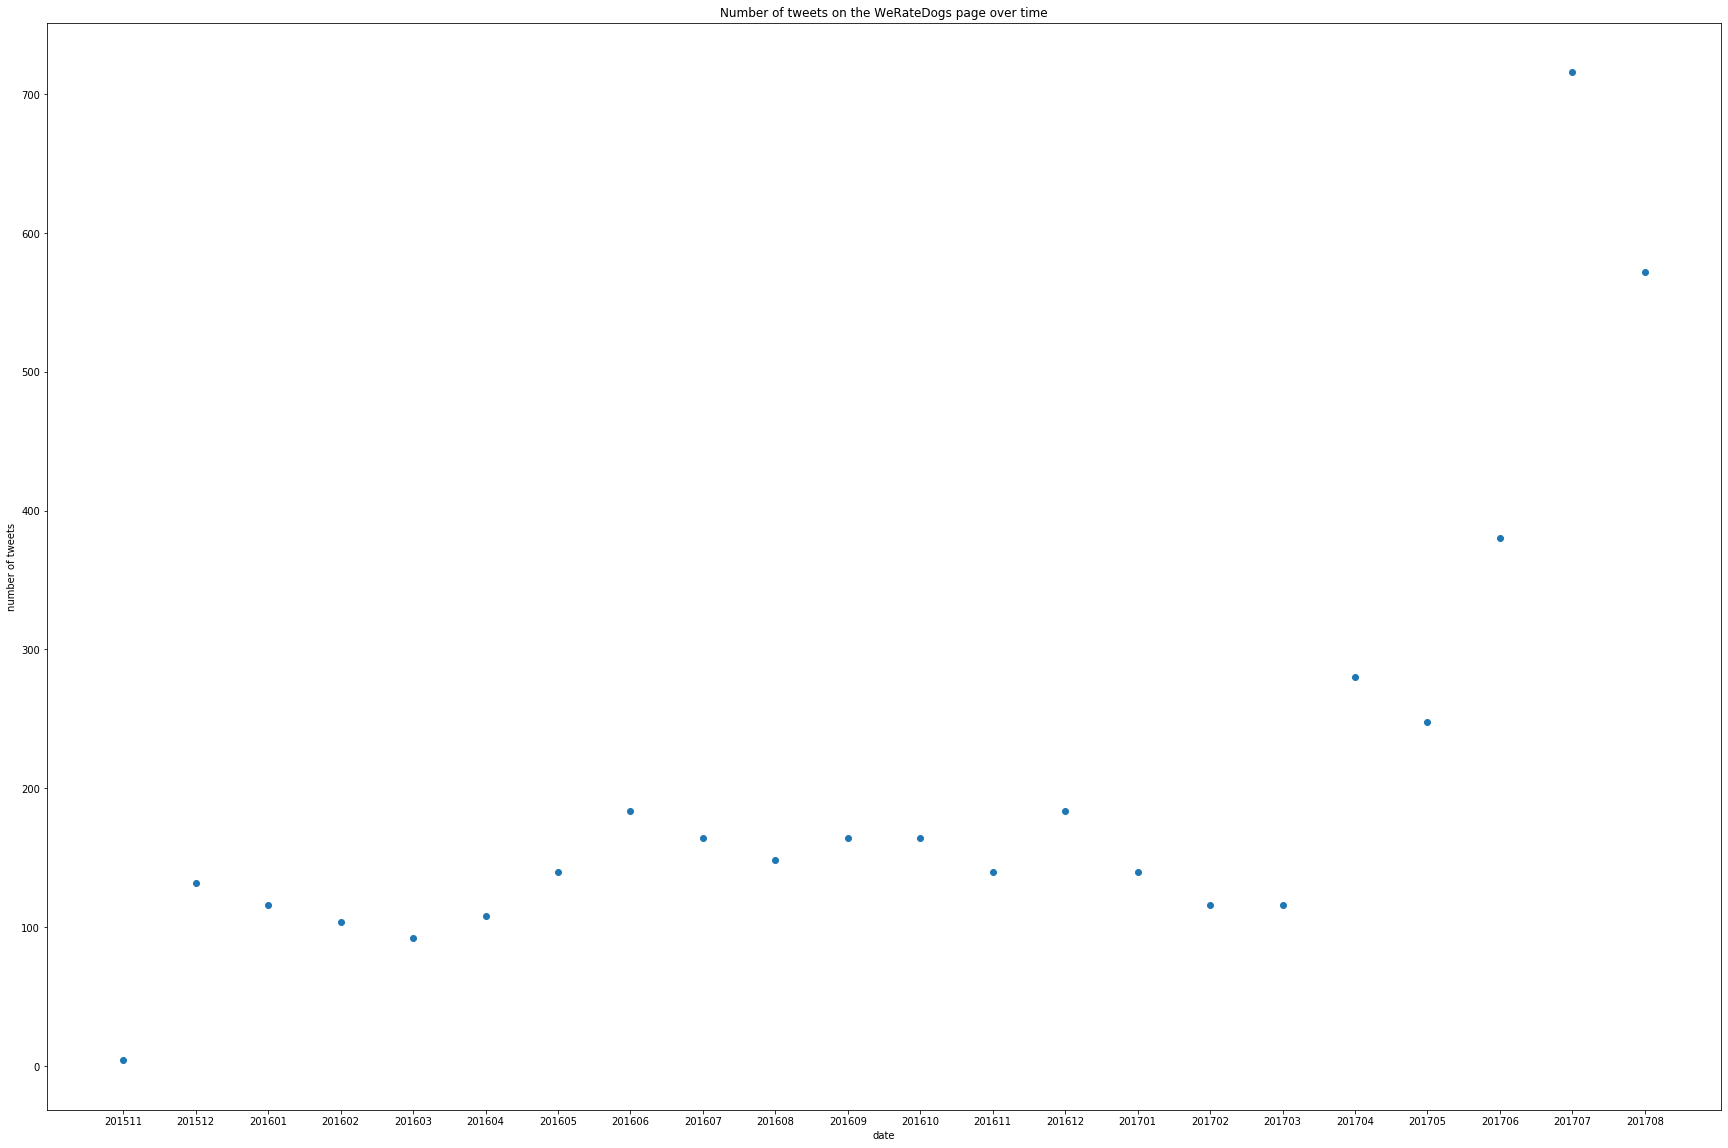

In [64]:
plt.figure(figsize = (30, 20))
plt.scatter(x = tweet_count_df['my'], y =tweet_count_df['no_tweets'])
plt.xlabel('date');
plt.ylabel('number of tweets')
plt.title('Number of tweets on the WeRateDogs page over time');

> Overall the number of tweets on the WeRateDogs page has increased steadily over a time, with a huge increase starting around March 2017. This means the page has gotten more popular over time. 